# K-Means, Hierarchical & DBScan on Amazon Reviews (Part II)


## Data Source: 
**The preprocessing step has produced final.sqlite file after doing the data preparation & cleaning.** The review text is now devoid of punctuations, HTML markups and stop words.

## Objective:
To find meaningful clusters using **unsupervised clustering algorithms like K-Means, Hierarchical & DBScan** on the review dataset. The **polarity of the review is removed from the input dataset,** so that the clustering would happen just on the review text given. 

4 standard featurizations are used, namely **BoW, tf-idf, W2V and tf-idf weighted W2V featurizations**. Cross validaton or test metrics in supervised algorithm cannot be used as there is no test data. Instead, **random samples from clusters formed are analyzed manually and a conclusion should be arrived at.**


## At a glance:

The **elbow method is used to find the right # of clusters of K-Means. The minPoints for DBScan is set as double the number of dimension of W2V vectors**, as a rule of thumb. The **Eps value is calculated using KNN distance plots.** The point at which the slope of the plot is higher than a set threshold is taken as Eps value.  

The hierarchical clustering algorithm is run with different 'k' values & DBScan also is executed with different Eps values. so that the impact of change in hyperparameters can be well understood.

# Preprocessed Data Loading

In [18]:
#loading libraries for LR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation
from sklearn.cluster import KMeans

#loading libraries for scikit learn, nlp, db, plot and matrix.
import sqlite3
import pdb
import pandas as pd
import numpy as np
import nltk
import string
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import tree

from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('./final.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
final = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

print(final.head(2))

    index      Id   ProductId          UserId      ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL  shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U            Tracy   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   

                                                                                                                                                                                                      Text  \
0  this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all t...   
1  I grew up reading 



# Random Sampling & Time Based Slicing

In [19]:
# To randomly sample the data and sort based on time before doing train/ test split.
# The slicing into train & test data is done thereafter.

# hierarchical cannot handle more points coz 
# of high time and space complexity
num_points_kmeans = 100000
num_points_hierarchical = 5000

# used to format headings 
bold = '\033[1m'
end = '\033[0m'

# ignore yi's for unsupervised learning
d_unsampled = final.drop(['Score'], axis=1)

# dataset for kmeans & DBSCAN clustering is d_kmeans
# you can use random_state for reproducibility
d_kmeans = d_unsampled.sample(n=num_points_kmeans, random_state=2)

# dataset for hierarchical
d_hierarchical = d_unsampled.sample(n=num_points_hierarchical, random_state=5)


# Custom Defined Functions

3 user defined functions are written to 

    a) Compute Mean Neighbourhood Distance & Distance Plot

    b) Elbow Method to find K
    
    c) Analyze the Clusters function.

# a) Compute Mean Neighbourhood Distance & Distance Plot

In [24]:
# For DBSCAN: Methods used to calculate the mean of the neighbors distances & 
# to calculate where the slope of the kNNdistPlot is higher than threshold
# Got base src from https://github.com/vincewide/ML_scheduler/blob/master/DBSCAN.py
# Modified to the fit in the requirements.

def Get_distanceMean(points,minPts,previous_distanceMean):

    """
    Method used to calculate the mean of the neighbors distances
    
    :param points: List containing the training-points you want to use
    :param minPts: Minimum number of points to be considered a cluster
    :param previous_distanceMean: The previous mean of the distances

    :return: Average distance between the points

    """

    if (minPts < len(points)):

        nbrs = NearestNeighbors(n_neighbors=minPts).fit(points)
        distances, indices = nbrs.kneighbors(points)
        d_mean = distances.mean()
        return d_mean

    else:
        return previous_distanceMean




def KNNdist_plot(points,minPts):

    """
    
    Calculate where the slope of the kNNdistPlot is higher than a user-defined
       value while plotting the K-NN distance 
           with respect to the amount of training data

   :param points: List containing the points you want to use
   :param minPts: Minimum number of points to be considered a cluster
   :return: The most optimal parameter-values i.e Knee point values

   """

    epsPlot = []
    current_distanceMean = previous_distanceMean = 0
    knee_value = knee_found = 0

    for i in range (0,len(points),5):

        current_distanceMean = Get_distanceMean(points[i:],
                                            minPts,previous_distanceMean)
        df = current_distanceMean - previous_distanceMean

        if (df > 0.02 and i > 1 and knee_found == 0):
            knee_value = current_distanceMean
            knee_found = 1
            n_trainingData = i

        epsPlot.append( [i,current_distanceMean] )
        previous_distanceMean = current_distanceMean


    #Plot the kNNdistPlot
    for i in range(0, len(epsPlot)):
                plt.scatter(epsPlot[i][0],epsPlot[i][1],c='r',s=3,marker='o')

    plt.axhline(y=knee_value, color='g', linestyle='-')
    plt.axvline(x=n_trainingData , color='g', linestyle='-')
#     plt.title(object_name)
    plt.show()

    print("Knee value: x=" + str(n_trainingData) + " , y=" + str(knee_value))

    return knee_value

# b) Elbow Method to find K

In [25]:
# To find K of K-means using elbow method.
# This fn plots the loss vs k graph to find the elbow point

def findK(d_vect_std):
    
    sse = {}
    for k in range(2, 20):
        kmeans = KMeans(n_clusters=k, max_iter=300).fit(d_vect_std)

        print(bold+"\nGroup Counter in Cluster %d is as follows:" % (k) +end)
        print(collections.Counter(kmeans.labels_))

        # Inertia: Sum of distances of samples to their closest cluster center
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("Loss Value")
    plt.show()


# c) Analyze the Clusters

In [26]:
# Using elbow method, optimal k is found. 
# This function analyze the clusters so formed.

def analyzeClusters(d_labels, k, algo='kmeans'):

    count = collections.Counter(d_labels)
    print("\n")
    print(type(count))
    print(count.items())
    print("cluster size = " + str(len(count.items())))
    k = len(count.items())

    if algo == 'kmeans':
        data = d_kmeans
        cluster_index_start = 1
    elif algo == 'hierarchical':
        data = d_hierarchical
        cluster_index_start = 1
    elif algo == 'dbscan':
        data = d_kmeans #change in last run
        cluster_index_start = 0

    print(bold+"\n*** CLUSTERS FORMED BY %s ALGORITHM is as follows: ***" %algo + end)

    for i in range(cluster_index_start, k+cluster_index_start):
        print("CLUSTER = " + str(i))
        # if point is noise then cluster index will be -1. hence exclude.
        if(count.get(i-1) > 1):

            print(bold+"\nThe Review Text in Cluster %d is as follows:" % (i-1) +end)
            print(data[d_labels == i-1].head(5)['Text'])
    
        else:
            print("Not enough datapoints to display in this cluster!")


# K-Means & Hierarchical Clustering on BoW 

BoW will result in a **sparse matrix with huge number of features** as it creates a feature for each unique word in the review.

For Binary BoW feature representation, CountVectorizer is declared as float, as the values can take non-integer values on further processing. 


Group Counter in Cluster 2 is as follows:
Counter({1: 99711, 0: 289})

Group Counter in Cluster 3 is as follows:
Counter({0: 99998, 1: 1, 2: 1})

Group Counter in Cluster 4 is as follows:
Counter({1: 99993, 0: 5, 2: 1, 3: 1})

Group Counter in Cluster 5 is as follows:
Counter({0: 99992, 3: 5, 2: 1, 4: 1, 1: 1})

Group Counter in Cluster 6 is as follows:
Counter({0: 99995, 2: 1, 1: 1, 3: 1, 5: 1, 4: 1})

Group Counter in Cluster 7 is as follows:
Counter({4: 99977, 0: 13, 1: 6, 3: 1, 5: 1, 2: 1, 6: 1})

Group Counter in Cluster 8 is as follows:
Counter({0: 99993, 4: 1, 7: 1, 5: 1, 2: 1, 3: 1, 1: 1, 6: 1})

Group Counter in Cluster 9 is as follows:
Counter({0: 99992, 3: 1, 6: 1, 7: 1, 2: 1, 1: 1, 8: 1, 4: 1, 5: 1})

Group Counter in Cluster 10 is as follows:
Counter({6: 99985, 4: 7, 9: 1, 3: 1, 2: 1, 8: 1, 5: 1, 7: 1, 0: 1, 1: 1})

Group Counter in Cluster 11 is as follows:
Counter({5: 99978, 0: 13, 6: 1, 7: 1, 2: 1, 8: 1, 10: 1, 1: 1, 4: 1, 9: 1, 3: 1})

Group Counter in Cluster 12 is a

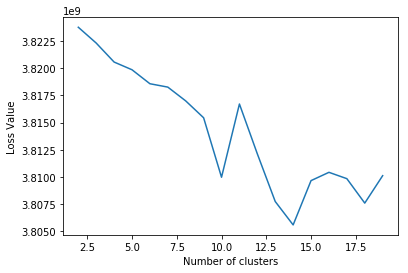

In [ ]:
# BoW Featurisation, Standardisation, Grid Search 

from sklearn.random_projection import sparse_random_matrix
from sklearn.preprocessing import StandardScaler

#########################################################
### BoW for K-means: Vectorization & Standardization ###
count_vect = CountVectorizer(dtype="float") #in scikit-learn
d_kmeans_vect = count_vect.fit_transform(d_kmeans['CleanedText'].values)
d_kmeans_vect.get_shape()

# Standardisation. Set "with_mean=False" to preserve sparsity
scaler = StandardScaler(copy=False, with_mean=False).fit(d_kmeans_vect)
d_kmeans_bow_vect_std = scaler.transform(d_kmeans_vect)

#########################################################

### BoW for Hierarchical: Vectorization & Standardization ###
count_vect = CountVectorizer(dtype="float") #in scikit-learn
d_hier_vect = count_vect.fit_transform(d_hierarchical['CleanedText'].values)
d_hier_vect.get_shape()

# Standardisation. Set "with_mean=False" to preserve sparsity
scaler = StandardScaler(copy=False, with_mean=False).fit(d_hier_vect)
d_hier_bow_vect_std = scaler.transform(d_hier_vect)

#########################################################

## To find the best K for K-means
k = findK(d_kmeans_bow_vect_std)

# Hierarchical Clustering
hierarchichal = AgglomerativeClustering(n_clusters=2).fit(
                                    d_hier_bow_vect_std.toarray())




In [ ]:
# from the above elbow plot, k = 10 is found to be optimum

# Analyse review in k clusters. 
# k is found using elbow method plot above.

pd.options.display.max_colwidth = 200

# Analyze clusters formed by kmeans clustering
kmeans = KMeans(n_clusters=10, max_iter=300).fit(d_kmeans_bow_vect_std)
analyzeClusters(d_labels=kmeans.labels_, k=10, algo='kmeans')

# Analyze clusters formed by hierarchical clustering
analyzeClusters(d_labels=hierarchichal.labels_, k=2, algo='hierarchical')




<class 'collections.Counter'>
dict_items([(2, 99983), (0, 4), (7, 1), (1, 6), (3, 1), (9, 1), (8, 1), (4, 1), (5, 1), (6, 1)])
cluster size = 10

*** CLUSTERS FORMED BY kmeans ALGORITHM is as follows: ***
CLUSTER = 1

The Review Text in Cluster 0 is as follows:
201895    While this honey is not so versatile in its application as a clover, acacia, or other flower honey, it is great for rolls, biscuits, or other things that allow the subtle cranberry flavor to emerg...
37529     Revised 4-2-12<br /><br />I love Stash's Green Tea, and their Chamomile is fantastic. In short, I have always enjoyed Stash teas.<br /><br />I first found this Raspberry & White atrocious, but tha...
128330    My middle poodle, Tucker, (the almost 4 year old) is a few lbs. overweight.  Tucker LOVES this food.  I feed my baby poodle, Milo (the almost 2 year old) and my oldest poodle, Bosco (the 13 year o...
197357    We discovered this finishing sauce when a friend of ours from St Louis prepared dinner for us an

# K-Means & Hierarchical Clustering on tf-IDF 

**Sparse matrix generated from tf-IDF ** is fed in to GridSearch GBDT Cross Validator & RF Cross Validator to find the optimal depth value. Performance metrics of optimal GBDT with tf-idf featurization is found.

C:\Users\Anand\Anaconda3\envs\myenv\lib\site-packages\sklearn\feature_extraction\text.py:1547: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float 'dtype' will be converted to np.float64.
  UserWarning)



Group Counter in Cluster 2 is as follows:
Counter({0: 99999, 1: 1})

Group Counter in Cluster 3 is as follows:
Counter({2: 99968, 1: 27, 0: 5})

Group Counter in Cluster 4 is as follows:
Counter({0: 99997, 3: 1, 2: 1, 1: 1})

Group Counter in Cluster 5 is as follows:
Counter({1: 99996, 2: 1, 0: 1, 3: 1, 4: 1})

Group Counter in Cluster 6 is as follows:
Counter({2: 99994, 0: 2, 3: 1, 5: 1, 1: 1, 4: 1})

Group Counter in Cluster 7 is as follows:
Counter({5: 99948, 4: 25, 3: 14, 0: 10, 2: 1, 6: 1, 1: 1})

Group Counter in Cluster 8 is as follows:
Counter({0: 99993, 2: 1, 6: 1, 7: 1, 1: 1, 4: 1, 3: 1, 5: 1})

Group Counter in Cluster 9 is as follows:
Counter({0: 99992, 2: 1, 4: 1, 8: 1, 7: 1, 1: 1, 5: 1, 6: 1, 3: 1})

Group Counter in Cluster 10 is as follows:
Counter({1: 99987, 0: 4, 8: 2, 9: 1, 6: 1, 2: 1, 4: 1, 3: 1, 7: 1, 5: 1})

Group Counter in Cluster 11 is as follows:
Counter({9: 99816, 0: 104, 2: 53, 1: 19, 3: 2, 6: 1, 7: 1, 8: 1, 4: 1, 10: 1, 5: 1})

Group Counter in Cluster 12 

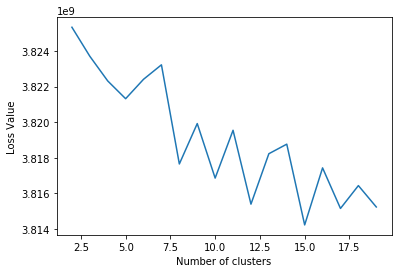

In [ ]:
# TFID Featurisation, Standardisation, Grid Search 

from sklearn.random_projection import sparse_random_matrix

# # TFID
# count_vect = TfidfVectorizer(dtype="float") #in scikit-learn
# d_vect = count_vect.fit_transform(d['CleanedText'].values)
# d_vect.get_shape()

# # Standardisation. Set "with_mean=False" to preserve sparsity
# scaler = StandardScaler(copy=False, with_mean=False).fit(d_vect)
# d_tfidf_vect_std = scaler.transform(d_vect)

# findK(d_tfidf_vect_std)



#########################################################
### TFID for K-means: Vectorization & Standardization ###
count_vect = TfidfVectorizer(dtype="float") #in scikit-learn
d_kmeans_vect = count_vect.fit_transform(d_kmeans['CleanedText'].values)
d_kmeans_vect.get_shape()

# Standardisation. Set "with_mean=False" to preserve sparsity
scaler = StandardScaler(copy=False, with_mean=False).fit(d_kmeans_vect)
d_kmeans_bow_vect_std = scaler.transform(d_kmeans_vect)

#########################################################

### TFID for Hierarchical: Vectorization & Standardization ###
count_vect = TfidfVectorizer(dtype="float") #in scikit-learn
d_hier_vect = count_vect.fit_transform(d_hierarchical['CleanedText'].values)
d_hier_vect.get_shape()

# Standardisation. Set "with_mean=False" to preserve sparsity
scaler = StandardScaler(copy=False, with_mean=False).fit(d_hier_vect)
d_hier_bow_vect_std = scaler.transform(d_hier_vect)

#########################################################

## To find the best K for K-means
k = findK(d_kmeans_bow_vect_std)

# Hierarchical Clustering
hierarchichal = AgglomerativeClustering(n_clusters=2).fit(
                                        d_hier_bow_vect_std.toarray())




In [ ]:
# To analyze clusters formed by kmeans & hierarchical clustering

# Analyse review in k clusters. 
# k is found using elbow method plot above.
# from the above elbow plot, k = 12 is found to be optimum for K-means

pd.options.display.max_colwidth = 200

# Analyze clusters formed by kmeans clustering
kmeans = KMeans(n_clusters=12, max_iter=300).fit(d_kmeans_bow_vect_std)
analyzeClusters(d_labels=kmeans.labels_, k=12, algo='kmeans')

# Analyze clusters formed by hierarchical clustering
analyzeClusters(d_labels=hierarchichal.labels_, k=2, algo='hierarchical')



<class 'collections.Counter'>
dict_items([(3, 99963), (0, 18), (4, 1), (2, 5), (1, 6), (7, 1), (5, 1), (8, 1), (9, 1), (6, 1), (10, 1), (11, 1)])
cluster size = 12

*** CLUSTERS FORMED BY kmeans ALGORITHM is as follows: ***
CLUSTER = 1

The Review Text in Cluster 0 is as follows:
111341    Does ganoderma do all it's said to do?  Heck, I don't know.  I do know that when I drink it in the morning, I seem to think more clearly throughout the day.  At 60, this is a good thing.  I also d...
66495     Navitas notes that their Maca is slow dried and not irradiated.  The product arrived to my mailbox in perfect condition within a few days of my order.  The powder comes in a resealable package.  T...
206098    In reading the reviews here it is obvious that different tastebuds are affected very differently.  At first I believed the tablets did nothing even though I used a whole one.  Bitter foods and dri...
44157     Is it Tea Magic, the placebo effect, or the actual tea that creates such a re

# K-Means, Hierarchical Clustering & DBScan on Word2Vec

**Dense matrix generated from Word2Vec ** is fed in to GridSearch GBDT Cross Validator & RF Cross Validator to find the optimal depth value. Performance metrics of GBDT and RF with W2V featurization is found. 


In [27]:
# Train your own Word2Vec model using your own text corpus
import gensim
import re

w2v_dim = 100

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

def trainW2V_model(reviewText):
    #select subset of points for fast execution
    i=0
    list_of_sent=[]

    for sent in reviewText:
        sent = str(sent, 'utf-8')
        filtered_sentence=[]
        sent=cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):    
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue 
        list_of_sent.append(filtered_sentence)

    w2v_model=gensim.models.Word2Vec(list_of_sent,
                                     min_count=5,size=w2v_dim, workers=4) 
    
    return w2v_model

In [28]:
# average Word2Vec
# compute average word2vec for each review.

def computeAvgW2V(w2vTrained_model, reviewText):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list

    for sent in reviewText: # for each review/sentence
        sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        sent = str(sent, 'utf-8')
        sent = re.sub("[^\w]", " ",  sent).split()

        for word in sent: # for each word in a review/sentence
            try:
                vec = w2vTrained_model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    return np.nan_to_num(sent_vectors)


C:\Users\Anand\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


***before finding k***

Group Counter in Cluster 2 is as follows:
Counter({0: 72190, 1: 27810})

Group Counter in Cluster 3 is as follows:
Counter({2: 41502, 1: 40864, 0: 17634})

Group Counter in Cluster 4 is as follows:
Counter({1: 41374, 0: 25604, 2: 17063, 3: 15959})

Group Counter in Cluster 5 is as follows:
Counter({1: 25283, 0: 23856, 4: 19574, 2: 16064, 3: 15223})

Group Counter in Cluster 6 is as follows:
Counter({3: 23529, 5: 21573, 4: 16838, 2: 15234, 1: 12577, 0: 10249})

Group Counter in Cluster 7 is as follows:
Counter({6: 18659, 3: 16382, 2: 15693, 4: 14491, 1: 12558, 5: 11754, 0: 10463})

Group Counter in Cluster 8 is as follows:
Counter({0: 18249, 5: 16077, 2: 15194, 6: 14860, 3: 11542, 4: 10381, 7: 7991, 1: 5706})

Group Counter in Cluster 9 is as follows:
Counter({3: 18001, 0: 14262, 6: 13702, 4: 11393, 2: 11026, 1: 9300, 8: 8796, 7: 7862, 5: 5658})

Group Counter in Cluster 10 is as follows:
Counter({9: 15201, 8: 12310, 6: 11530, 1: 10788, 3: 10319, 7: 9518, 0: 8718

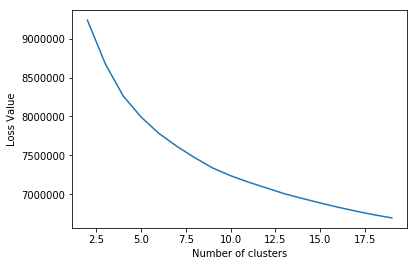

***before clustering***
***after 1st clustering***
***after 2nd clustering***


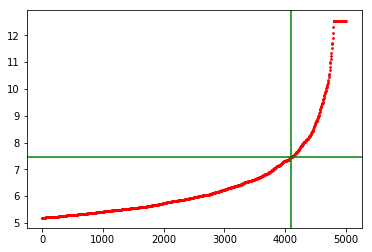

Knee value: x=4095 , y=7.465998466888701
***ended clustering***


In [29]:
# W2V Main Function
# W2V Featurisation, Standardisation, Grid Search and Random Search, 
# Perturbation test to remove multicollinear features

from sklearn.preprocessing import StandardScaler

#########################################################
### W2V for K-means: Vectorization & Standardization ###
# W2V Train
w2v_kmeans_Model = trainW2V_model(d_kmeans['CleanedText'].values)
d_kmeans_vect = computeAvgW2V(w2v_kmeans_Model, d_kmeans['CleanedText'].values)

# Standardisation. 
scaler = StandardScaler(copy=False).fit(d_kmeans_vect)
d_w2v_kmeans_vect_std = scaler.transform(d_kmeans_vect)

#########################################################
### W2V for Hierarchical: Vectorization & Standardization ###
w2v_hier_Model = trainW2V_model(d_hierarchical['CleanedText'].values)
d_hier_vect = computeAvgW2V(w2v_hier_Model, d_hierarchical['CleanedText'].values)

# Standardisation. 
scaler = StandardScaler(copy=False).fit(d_hier_vect)
d_w2v_heir_vect_std = scaler.transform(d_hier_vect)

#########################################################
print("***before finding k***")
## To find the best K for K-means
findK(d_w2v_kmeans_vect_std)

print("***before clustering***")
# Hierarchical Clustering
hierarchichal = AgglomerativeClustering(n_clusters=2).fit(d_w2v_heir_vect_std)

print("***after 1st clustering***")
# Hierarchical Clustering - different K
hierarchichal_test = AgglomerativeClustering(n_clusters=5).fit(d_w2v_heir_vect_std)

print("***after 2nd clustering***")
# by rule of thumb, min_samples should be 2*dimensionality = 200
# we need to estimate eps value by doing an elbow plot.
kneeValue = KNNdist_plot(d_w2v_heir_vect_std,200)
print("***ended clustering***")


In [30]:
# from the above elbow plot, k = 15 is found to be optimum

# Analyse review in k clusters. 
# k is found using elbow method plot above.

pd.options.display.max_colwidth = 200
# analyzeClusters(d_vect_std=d_w2v_vect_std, k=15)

print("***before kmeans clustering***")
# Analyze clusters formed by kmeans clustering
kmeans = KMeans(n_clusters=15, max_iter=300).fit(d_w2v_kmeans_vect_std)
analyzeClusters(d_labels=kmeans.labels_, k=15, algo='kmeans')

print("***before heir clustering***")
# Analyze clusters formed by hierarchical clustering
analyzeClusters(d_labels=hierarchichal.labels_, k=2, algo='hierarchical')

print("***before 2nd heir clustering***")
# Analyze clusters formed by hierarchical clustering
print(bold + "%%% Hierarchical Clustering with 5 Clusters %%%" + end)
analyzeClusters(d_labels=hierarchichal_test.labels_, k=5, algo='hierarchical')

print("***ended heir clustering***")

#### eps = kneeValue from the above plot
# Analyze clusters formed by DBSCAN clustering
# by rule of thumb, min_samples should be 2*dimensionality = 200
# set function is used to determine unique values.
dbscan = DBSCAN(eps=kneeValue, min_samples=200).fit(d_w2v_kmeans_vect_std)
analyzeClusters(d_labels=dbscan.labels_, k=len(set(dbscan.labels_)), algo='dbscan')
print("***after dbscan clustering***")

# To try out other Eps values
# by rule of thumb, min_samples should be 2*dimensionality = 200
print(bold + "%%% DBSCAN Clustering with Eps = 1 %%%" + end)
dbscan = DBSCAN(eps=1, min_samples=200).fit(d_w2v_kmeans_vect_std)
print(len(set(dbscan.labels_)))
analyzeClusters(d_labels=dbscan.labels_, k=len(set(dbscan.labels_)), algo='dbscan')

print("***after 2nd dbscan clustering***")

print(bold + "%%% DBSCAN Clustering with Eps = 50 %%%" + end)
dbscan = DBSCAN(eps=10, min_samples=200).fit(d_w2v_kmeans_vect_std)
print(len(set(dbscan.labels_)))
analyzeClusters(d_labels=dbscan.labels_, k=len(set(dbscan.labels_)), algo='dbscan')

print("***after 3rd dbscan clustering***")


***before kmeans clustering***


<class 'collections.Counter'>
dict_items([(0, 8632), (5, 7130), (1, 10642), (6, 8074), (12, 4014), (2, 7476), (4, 5995), (14, 6020), (8, 4907), (13, 6711), (11, 6805), (3, 7284), (7, 5287), (10, 4318), (9, 6705)])
cluster size = 15

*** CLUSTERS FORMED BY kmeans ALGORITHM is as follows: ***
CLUSTER = 1

The Review Text in Cluster 0 is as follows:
297698    I have used it many times and the flavor is wonderful. I highly recommend it, it is free of processed sugars and flours. I sauteed chicken in a little organic cold-pressed extra virgin coconut oil...
37085     I got this pasta for my 14 month old and she loves it. I hated giving her the Kraft with all the extra stuff we don't need in it. I don't follow the directions very well though, i just put the mil...
73433     This is a real gourmet product. You can add them to melon cut in dices and it makes an excellent entr&eacute;e. You can add to ice cream as well,and unless you are anti alcohol, no one wil



<class 'collections.Counter'>
dict_items([(0, 73431), (-1, 26569)])
cluster size = 2

*** CLUSTERS FORMED BY dbscan ALGORITHM is as follows: ***
CLUSTER = 0

The Review Text in Cluster -1 is as follows:
63408                                                            my wife and I enjoy cooking and we found this to be a convenient alternative for our pantry shelf.
311384                                       Cafe' Escapes Chai Latte K Cups-it taste so smooth and it's a quick treat for the middle of the Day just sweet enough.
190346                                               I'm happy with the Tahini that I purchased.  I think I got a good value and the product was delivered quickly.
363410    This is my favorite coconut milk. I used to buy it at my local safeway, but they have been out of it for weeks. My order was received in a timely matter.
110069                                                     These are low calorie treats for your dog.  Mine just loves them!  Highly recomm

# K-Means, Hierarchical Clustering & DBScan on TF-ID Weighted W2V

In [31]:
# average Word2Vec
# compute average word2vec for each review.

def compute_tfidW2V(w2v_model, model_tf_idf, count_vect, reviewText):

    # the tfidf-w2v for each sentence/review is stored in this list
    tfidf_sent_vectors = []; 
    row=0; 
    
    # TF-IDF weighted Word2Vec
    tfidf_feats = count_vect.get_feature_names() # tfidf words/col-names

    # iterate for each review/sentence
    for sent in reviewText: 
        sent_vec = np.zeros(w2v_dim) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        sent = str(sent, 'utf-8')
        sent = re.sub("[^\w]", " ",  sent).split()
        
        for word in sent: # for each word in a review/sentence
            try:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                tfidf = model_tf_idf[row, tfidf_feats.index(word)]
                sent_vec += (vec * tfidf)
                weight_sum += tfidf
            except:
                pass
        sent_vec /= weight_sum

        tfidf_sent_vectors.append(sent_vec)
        row += 1

    return np.nan_to_num(tfidf_sent_vectors)


C:\Users\Anand\Anaconda3\envs\myenv\lib\site-packages\sklearn\feature_extraction\text.py:1547: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float 'dtype' will be converted to np.float64.
  UserWarning)
C:\Users\Anand\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Anand\Anaconda3\envs\myenv\lib\site-packages\sklearn\feature_extraction\text.py:1547: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float 'dtype' will be converted to np.float64.
  UserWarning)



Group Counter in Cluster 2 is as follows:
Counter({0: 79235, 1: 20765})

Group Counter in Cluster 3 is as follows:
Counter({0: 43088, 1: 41398, 2: 15514})

Group Counter in Cluster 4 is as follows:
Counter({0: 42088, 3: 32424, 2: 14478, 1: 11010})

Group Counter in Cluster 5 is as follows:
Counter({3: 31167, 4: 27921, 2: 17134, 0: 13092, 1: 10686})

Group Counter in Cluster 6 is as follows:
Counter({4: 30965, 0: 28201, 1: 17170, 3: 10677, 2: 7925, 5: 5062})

Group Counter in Cluster 7 is as follows:
Counter({3: 27834, 2: 19639, 1: 16084, 0: 14591, 5: 10277, 4: 7342, 6: 4233})

Group Counter in Cluster 8 is as follows:
Counter({5: 24761, 7: 14315, 4: 14258, 0: 13673, 3: 13345, 1: 8256, 2: 7209, 6: 4183})

Group Counter in Cluster 9 is as follows:
Counter({3: 23171, 0: 13468, 8: 12756, 1: 12495, 6: 9891, 7: 8906, 5: 7993, 4: 7154, 2: 4166})

Group Counter in Cluster 10 is as follows:
Counter({0: 22837, 9: 12310, 5: 11389, 4: 11386, 7: 9753, 8: 8766, 1: 7936, 6: 7155, 2: 4304, 3: 4164})


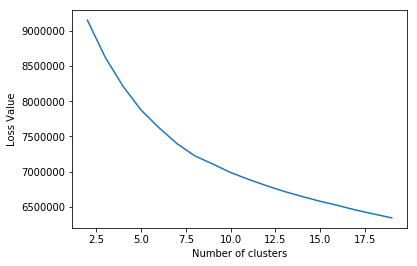

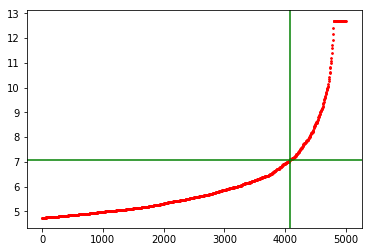

Knee value: x=4080 , y=7.083716272480987


In [32]:
# tf-df weighted W2V Main Function
# tfidf and W2V Featurisation, Standardisation, Grid Search 
# Perturbation test to remove multicollinear features

from sklearn.preprocessing import StandardScaler

############################################################
### TFIDW2V for K-means: Vectorization & Standardization ###
# TFID W2V Train
count_vect = TfidfVectorizer(dtype="float") #in scikit-learn
d_kmeans_tfidW2v_vect = count_vect.fit_transform(d_kmeans['CleanedText'].values)

d_kmeans_avg_vect = compute_tfidW2V(w2v_kmeans_Model, d_kmeans_tfidW2v_vect, 
                               count_vect, d_kmeans['CleanedText'].values)

# Standardisation. 
scaler = StandardScaler(copy=False).fit(d_kmeans_avg_vect)
d_tfidf_w2v_kmeans_vect_std = scaler.transform(d_kmeans_avg_vect)

############################################################
### TFIDW2V for Hierarchical: Vectorization & Standardization ###

count_vect = TfidfVectorizer(dtype="float") #in scikit-learn
d_hier_tfidW2v_vect = count_vect.fit_transform(d_hierarchical['CleanedText'].values)

d_hier_avg_vect = compute_tfidW2V(w2v_hier_Model, d_hier_tfidW2v_vect, 
                               count_vect, d_hierarchical['CleanedText'].values)

# Standardisation. 
scaler = StandardScaler(copy=False).fit(d_hier_avg_vect)
d_tfidf_w2v_hier_vect_std = scaler.transform(d_hier_avg_vect)
############################################################

## To find the best K for K-means
findK(d_tfidf_w2v_kmeans_vect_std)

# Hierarchical Clustering
hierarchichal = AgglomerativeClustering(n_clusters=2).fit(d_tfidf_w2v_hier_vect_std)

# Hierarchical Clustering - different K
hierarchichal_test = AgglomerativeClustering(n_clusters=5).fit(d_tfidf_w2v_hier_vect_std)

# by rule of thumb, min_samples should be 2*dimensionality = 200
# we need to estimate eps value by doing an elbow plot.
kneeValue = KNNdist_plot(d_tfidf_w2v_hier_vect_std,200)

In [33]:
# from sklearn.neighbors import NearestNeighbors


In [34]:
# Analyse review in k clusters. 
# k is found using elbow method plot above.

pd.options.display.max_colwidth = 200

# KMEANS
# Analyze clusters formed by kmeans clustering
kmeans = KMeans(n_clusters=15, max_iter=300).fit(d_tfidf_w2v_kmeans_vect_std)
analyzeClusters(d_labels=kmeans.labels_, k=15, algo='kmeans')

## HIERARCHICAL
# Analyze clusters formed by hierarchical clustering
analyzeClusters(d_labels=hierarchichal.labels_, k=2, algo='hierarchical')

# Analyze clusters formed by hierarchical clustering
print(bold + "%%% Hierarchical Clustering with 5 Clusters %%%" + end)
analyzeClusters(d_labels=hierarchichal_test.labels_, k=5, algo='hierarchical')


## DBSCAN
# by rule of thumb, min_samples should be 2*dimensionality = 200
dbscan = DBSCAN(eps=kneeValue, min_samples=200).fit(d_tfidf_w2v_kmeans_vect_std)
analyzeClusters(d_labels=dbscan.labels_, k=2, algo='dbscan')

# To try out other Eps values
# by rule of thumb, min_samples should be 2*dimensionality = 200
print(bold + "%%% DBSCAN Clustering with Eps = 1 %%%" + end)
dbscan = DBSCAN(eps=1, min_samples=200).fit(d_tfidf_w2v_kmeans_vect_std)
analyzeClusters(d_labels=dbscan.labels_, k=2, algo='dbscan')

print(bold + "%%% DBSCAN Clustering with Eps = 50 %%%" + end)
dbscan = DBSCAN(eps=10, min_samples=200).fit(d_tfidf_w2v_kmeans_vect_std)
analyzeClusters(d_labels=dbscan.labels_, k=2, algo='dbscan')




<class 'collections.Counter'>
dict_items([(14, 8390), (4, 6765), (7, 14818), (9, 7438), (5, 7182), (2, 6989), (10, 7369), (1, 4139), (0, 6426), (6, 9264), (13, 4037), (11, 3772), (8, 3696), (3, 2409), (12, 7306)])
cluster size = 15

*** CLUSTERS FORMED BY kmeans ALGORITHM is as follows: ***
CLUSTER = 1

The Review Text in Cluster 0 is as follows:
306512    The water is great but the price has me at a loss. I have been paying anywhere from $30.00 to $37.00 a case for this water. I have to question if this is the real deal. Other than that the water i...
204057    The Black Cherry Switch is an interesting beverage, a cross between the traditional carbonated drinks and fruit juice. As some of the other reviewers have noted, this is a very sweet drink, and I ...
175821    I have been hooked on crystal sugar like this ever since I used it when I worked for a bakery and we put it on scones, shortbread, and a few other things.<br /><br />This sugar has large crystals,...
228686    Arctic Ze



<class 'collections.Counter'>
dict_items([(0, 84671), (-1, 15329)])
cluster size = 2

*** CLUSTERS FORMED BY dbscan ALGORITHM is as follows: ***
CLUSTER = 0

The Review Text in Cluster -1 is as follows:
63408                                                                                                          my wife and I enjoy cooking and we found this to be a convenient alternative for our pantry shelf.
363410                                                  This is my favorite coconut milk. I used to buy it at my local safeway, but they have been out of it for weeks. My order was received in a timely matter.
110069                                                                                                   These are low calorie treats for your dog.  Mine just loves them!  Highly recommend the vendor also!!!!!
306512    The water is great but the price has me at a loss. I have been paying anywhere from $30.00 to $37.00 a case for this water. I have to question if this is t

# Observations

1) All the **clusters are formed based on word (or contextual similarities) and NOT on +ve or -ve review rating** as they are not given 'y' values as input, while clustering. 

2) The analysis of clusters formed using 4 featurizations are done.

> **A) BoW**

> > **K-Means:**

> > > **Cluster 0:** most reviews about taste of food derived from flavour.  
> > > **Cluster 1:** reviews focussed on 'work' environment products. Eg: office, work, colleagues, receptionist etc are repeated.  
> > > **Cluster 2:** groups reviews related to food. The repeated words are food, sugar, flours, oil etc.  


> > **Hierarchical:**

> > > The clustering is not meaningful as all points except 1, is grouped into 1 single cluster.  

> **B) tf-idf**

> > **K-Means:**  

> > > **Cluster 0:** customers are in dilemma. Whether the effectiveness is +ve or -ve or just placebo.  
> > > **Cluster 1:** talks about illness and effectiveness of medicines. Many medical terminologies.  
> > > **Cluster 2:** all reviews are about sound and equipments related to sound. Eg: mic, icicle, jack etc.  
> > > **Cluster 3:** groups reviews related to food. The repeated words are food, sugar, flours, oil etc.  

> > **Hierarchical:**

> > > The clustering is not meaningful as all points except 1, is grouped into 1 single cluster.  


> **C) Word2Vec:**

> > **K-Means:**  

> > From the cluster groups, it can be seen that the **reviews obtained from kmeans clustering are more distributed.**  

> > > **Cluster 0:** Reviews are going in-depth about using the purchased product for cooking. Eg: noodies, oil, chicken, ice cream, melons etc.  
> > > **Cluster 1:** There are some negative words (reviews) repeated, in this group. Some breakfast products are clubbed in this group. Eg: cornflakes, peanut butter etc.  
> > > **Cluster 2:** This group is all about drinks. Eg: coffee, chai, latte, cups, drink, chocolate etc are repeated.  
> > > **Cluster 3:** Extremely positive reviews. Most of the reviews are about products which are rarely available in the market, but only in Amazon. Logically, as customers were able to find such 'hard-gets', they are extremely happy.  
> > > **Cluster 4:** This group focus on delivery and damage caused for the shipment.  
> > > **Cluster 5:** Most of the reviews are about bakery food items. Product reviews are about chocolate syrup, scones, shortbread, ice cream, carbonated drinks and fruit juice etc.  
> > > **Cluster 6:** Groups products available in amazon, vis-a-vis offline stores.  
> > > **Cluster 7:** This group is all about tea and tea products.  
> > > **Cluster 8:** This group is all about pets, mostly dog and cats.  
> > > **Cluster 9:** Group focus on energy drinks and health drinks.  
> > > **Cluster 10:** Groups reviews about Bread and associated combinations.  
> > > **Cluster 11:** Very personal opinion about the products are shared.  
> > > **Cluster 12:** This group is all about dog food and cat food.  
> > > **Cluster 13:** Groups reviews about healthy related products and meal replacements. Eg: protein bars, energy bars, pirate booty, healthy cereal etc.  
> > > **Clusters 14:** Snacks & toffees are grouped. Eg: rice chips, toffee, pepper, berger, chocolate etc.  

> > **Hierarchical:**  

> > The first 2 clusters formed when K=2 & K=5 are similar.  

> > > **Cluster 0:** Groups reviews about snacks and sauces.  
> > > **Cluster 1:** Groups cuisines of different cultures.  
> > > **Cluster 2:** Groups tea and coffee reviews.  
> > > **Cluster 3:** Nothing found in common.  
> > > **Clsuter 4:** Groups dog and cat foods.  

> > **DBSCAN:**  

> > The Eps value is found out using Min Points value. 2 Clusters are formed while using the computed Eps value. One cluster has id of -1, which means they are identified as noise. When Eps value is reduced all the points are identified as noise, whereas, when the Eps value is increased, then number of noise points drastically reduced.  

> **D) tf-idf W2V:**  

> > **K-Means:**  

> > The 15 clusters formed via tf-idf weighted W2V vectors have **similar grouping pattern compared to W2V vectors. The cluster separation may be slightly more meaningful** than using W2V alone, but they are not significantly better.  

> > **Hierarchical:**  

> > The 5 clusters formed are **similar to the groups obtained from W2V method, but they are more meaningfully separated**. For instance, Cluster 3 talks only about dogs and dog foods, whil Cluster 4 contains reviews about different variants of tea, such as black tea, green tea etc.  

> > **DBSCAN:**  

> > The DBSCAN results shows similar results as with W2V vector. When Eps value is reduced all the points are identified as noise, whereas, when the Eps value is increased, noise points are reduced.  

3) From the above analysis, it can deduced that **K-Means algorithm on TF-ID Weighted W2V or Word2Vec is the clustering algorithm of choice.**
